# Прогнозирование вероятности оттока пользователей для фитнес-центров

**Описание проекта:**

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.
Распространённая проблема фитнес-клубов и других сервисов — отток клиентов.
Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. Наша задача — провести анализ и подготовить план действий по удержанию клиентов.
А именно:
* научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
* сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
* проанализировать основные признаки, наиболее сильно влияющие на отток;
* сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
1) выделить целевые группы клиентов;
2) предложить меры по снижению оттока;
3) определить другие особенности взаимодействия с клиентами.

## Загрузка даннх

Импортируем необходимые библиотеки.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans

Для обзора данных воспользуемся методами head() и info().

In [2]:
data = pd.read_csv('gym_churn.csv')
data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

После первого знакомства с данными, можно сделать выводы:

* В данных нет пропусков, но нужно проверить на наличие дубликатов;
* Для удобства необходимо привести данные к нижнему регистру;

Это только первоначальные наблюдения. Проведем подробную предобработку данных, чтобы выявить наличие аномалий. 

## Провести исследовательский анализ данных (EDA)

1. Проверим данные на дубликаты. 

In [4]:
data.duplicated().sum() 

0

Дубликатов нет. 

2. Приведем данные к нижнему регистру. 

In [5]:
data.columns = data.columns.str.lower()
data.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

3. Применим метод describe(). Он используется для предоставления всей необходимой информации о набор данных. 

In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


Из данных выше можно сделать выводы, что:
* По полу посетители распределены примерно одинаково;
* Почти 85% посетителей проживают или работают в районе, где находится фитнес-центр;
* Почти половина всех посетителей являются сотрудниками компании-партнеров клуба; 
* 30% посетителей первоначально записались на посещение клуба в рамках акции «приведи друга»; 
* 90% посетители оставили свой контактный телефон;             
* Средняя длительность текущих действующих абонементов чуть меньше 4.6 месяцев;
* 41% посетителей посещают групповые занятия;
* Средний возрасти посетителей составляет 29 лет;
* В среднем суммарная выручка от других услуг фитнес-центра составляет 146.9;
* Средний срок до окончания текущих действующих абонементов составляет чуть больше 4 месяцев;
* Среднее время с момента первого обращения в фитнес-центр составляет 3.7 месяцев;
* Средняя частота посещений в неделю за все время с начала действия абонемента составляет 1.87 раз в неделю; 
* Средняя частота посещений в неделю за предыдущий месяц составляет 1.76 раз в неделю; 
* Среднее значение оттока составляет 26.5%.

Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался. Для этой цели создадим 2 датафрейма: churn_yes - для тех, кто ушел, churn_no - для тех, кто остался. 

In [7]:
churn_yes = data[data['churn'] == 1] #факт оттока - да
churn_no = data[data['churn'] == 0] #факт оттока - нет
display(churn_yes.describe().T)
churn_no.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,1061.0,0.510839,0.500118,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,1061.0,0.768143,0.422217,0.000000,1.000000,1.000000,1.000000,1.000000
partner,1061.0,0.355325,0.478837,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,1061.0,0.183789,0.387495,0.000000,0.000000,0.000000,0.000000,1.000000
phone,1061.0,0.902922,0.296204,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,1061.0,1.728558,2.132371,1.000000,1.000000,1.000000,1.000000,12.000000
group_visits,1061.0,0.268615,0.443448,0.000000,0.000000,0.000000,1.000000,1.000000
age,1061.0,26.989632,2.895163,18.000000,25.000000,27.000000,29.000000,38.000000
avg_additional_charges_total,1061.0,115.082899,77.696419,0.148205,50.629127,103.814686,165.616858,425.535220
month_to_end_contract,1061.0,1.662582,1.964593,1.000000,1.000000,1.000000,1.000000,12.000000


,count,mean,std,min,25%,50%,75%,max
gender,2939.0,0.510037,0.499984,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,2939.0,0.873086,0.332933,0.000000,1.000000,1.000000,1.000000,1.000000
partner,2939.0,0.534195,0.498914,0.000000,0.000000,1.000000,1.000000,1.000000
promo_friends,2939.0,0.353522,0.478144,0.000000,0.000000,0.000000,1.000000,1.000000
phone,2939.0,0.903709,0.295040,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,2939.0,5.747193,4.716942,1.000000,1.000000,6.000000,12.000000,12.000000
group_visits,2939.0,0.464103,0.498795,0.000000,0.000000,0.000000,1.000000,1.000000
age,2939.0,29.976523,3.009933,19.000000,28.000000,30.000000,32.000000,41.000000
avg_additional_charges_total,2939.0,158.445715,99.801599,0.171862,76.920993,149.881171,224.448274,552.590740
month_to_end_contract,2939.0,5.283089,4.363522,1.000000,1.000000,6.000000,10.000000,12.000000


Клиентов, продолжающих посещать фитнес-центр почти в 3 раза больше, чем тех, кто ушел в отток. Сделали следующие выводы: 

* Распределение по полу в обеих группах примерно одинаково;
* В обеих группах большинство посетителей живут или работают в районе, где находится фитнес-центр. Также стоит заметить, что ближе живущие или работающие клиенты реже попадают в отток; 
* Для **группы оставшихся** (не попавших в отток) половина всех посетителей являются сотрудниками компаний-партнеров клуба. В **группе "оттока"** их всего 35%; 
* **Группа оставшихся** (не попавших в отток) - 35% посетителей первоначально записались на посещение клуба в рамках акции «приведи друга». **Группа "оттока"** - всего 18% посетителей первоначально записались по данной акции;
* В обеих группах 90% посетители оставили свой контактный телефон; 
* **Группа оставшихся** -- средняя длительность текущих действующих абонементов 5.7 месяцев. **Группа "оттока"** - 1.7 месяцев; 
* **Группа оставшихся** -- 46% клиентов посещают групповые занятия. **Группа "оттока"** - всего 26% клиентов; 
* Средний возраст в **Группе оставшихся** около 30 лет. В **группе "оттока"** посетители чуть младше, средний возраст 27 лет; 
* **Группа оставшихся** -- в среднем суммарная выручка от других услуг фитнес-центра составляет 158.4. **Группа "оттока"** всего 115; 
* **Группа оставшихся** -- средний срок до окончания текущих действующих абонементов составляет 5.2 месяца. Для **группы "оттока"** всего 1.6 месяцев;
* **Группа оставшихся** -- среднее время с момента первого обращения в фитнес-центр составляет 4.7 месяцев. Для **группы "оттока"** менее 1 месяца;
* **Группа оставшихся** - средняя частота посещений в неделю за все время с начала действия абонемента составляет 2 раз в неделю; Для **группы "оттока"** -- 1.4 раз в неделю;
* **Группа оставшихся** -- средняя частота посещений в неделю за предыдущий месяц составляет 2 раз в неделю; Для **группы "оттока"** - 1 раз в неделю. 

Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток). В наших данных встречаются категориальные и числовые данные. Построим для них разные типы графиков. 

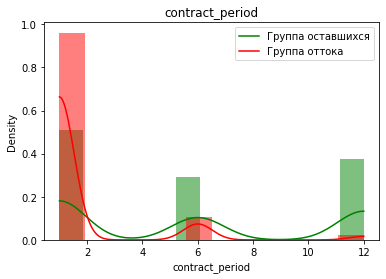

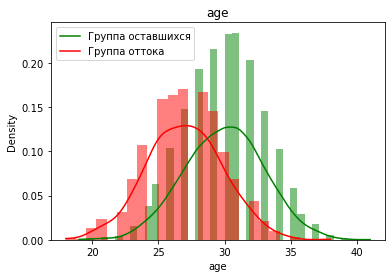

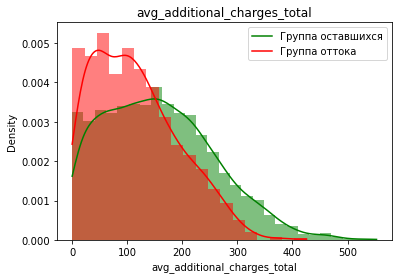

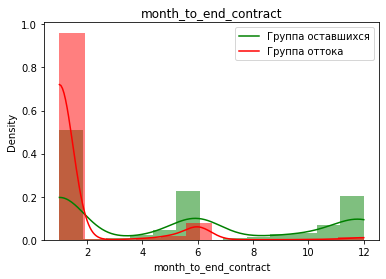

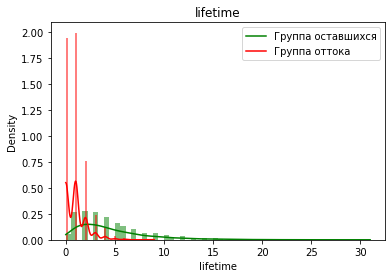

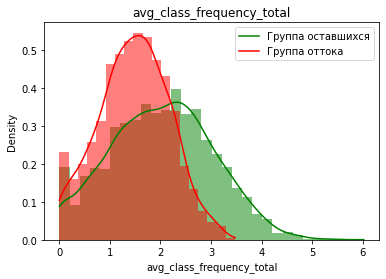

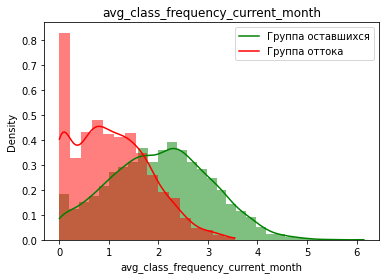

In [8]:
numerical_features = ['contract_period', 'age', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime', 
                      'avg_class_frequency_total', 'avg_class_frequency_current_month']
for n in numerical_features:
    sns.histplot(churn_no[n], color="green", kde=True, stat="density", linewidth=0)
    sns.histplot(churn_yes[n], color="red", kde=True, stat="density", linewidth=0)
    plt.title(n)
    plt.legend(['Группа оставшихся', 'Группа оттока'])
    plt.show()

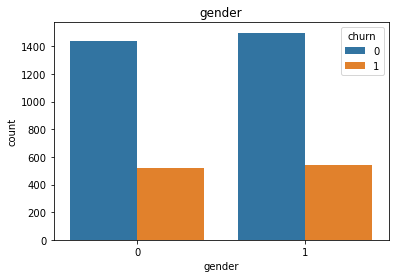

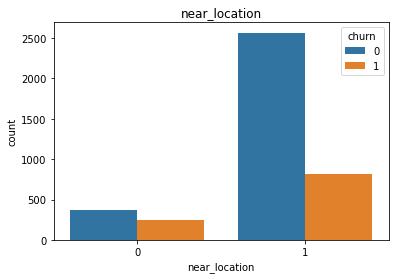

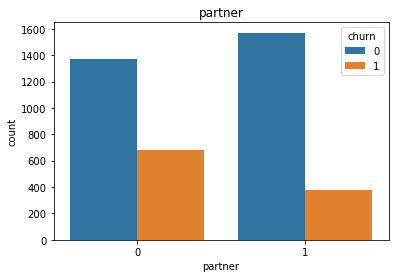

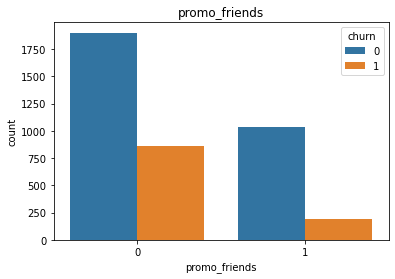

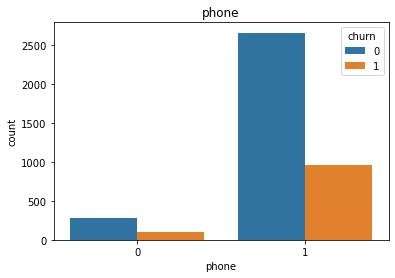

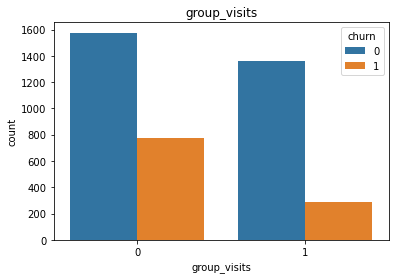

In [9]:
categorical_features = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']

for c in categorical_features:
    sns.countplot(x = data[c], hue='churn', data=data)
    plt.title(c)
    plt.show()

Построим матрицу корреляций.

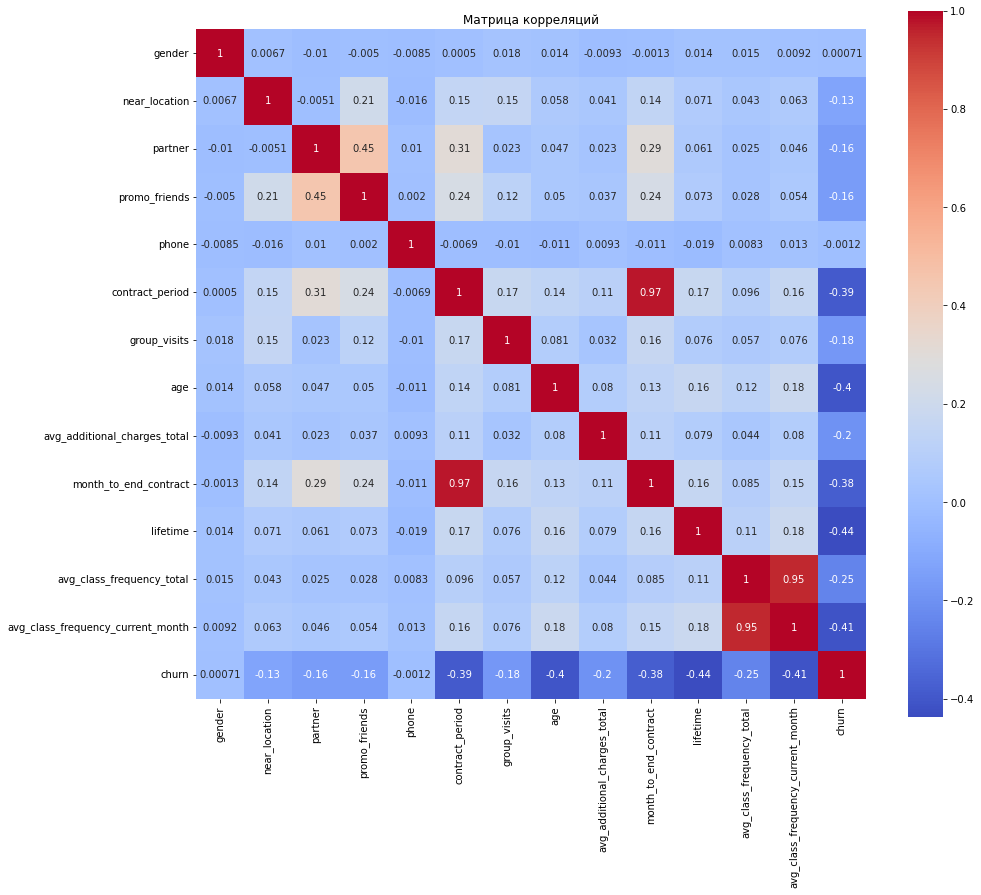

In [10]:
data_corr = data.corr() 
plt.figure(figsize=(15,13))
sns.heatmap(data_corr, annot=True, square=True, cmap='coolwarm' )
plt.title('Матрица корреляций')
plt.show()

Из графика видно, что:

* сильной корреляционной связи между признак-таргет нет. 
* на графике встречается высокая корреляция между признаками (мультиколлинеарность) - month_to_end_contact и contract_period, avg_class_frequency_total и avg_class_frequency_current_month. 
* признаки gender и phone не влияют на отток.
* признаки lifetime, avg_class_frequency_current_month, age, contract_period, month_to_end_contract имеют наибольшее влияние на отток.

## Построить модель прогнозирования оттока клиентов

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце. Первостепенной задачей является разбивка данных на обучающую и вариационную выборки. Используем функцию train_test_split(). 

In [11]:
# разделим данные на признаки (матрица X) и целевую переменную (y)
X = data.drop('churn', axis=1) 
y = data['churn'] 

In [12]:
# разделяем модель на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) 

Далее нам необходимо создать объект класса StandardScaler и применить его к обучающей выборке. 

In [13]:
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)

Применим стандартизацию к матрице признаков для тестовой выборки. 

In [14]:
X_test_st = scaler.transform(X_test)

Нам необходимо обучить модель на train-выборке двумя моделями: логистической регрессией и случайным лесом. Начнем по порядку, с логистической регрессии, она реализована как класс LogisticRegression(). 

In [15]:
model = LogisticRegression(solver='liblinear', random_state=0)
model.fit(X_train_st, y_train)

LogisticRegression(random_state=0, solver='liblinear')

Воспользуемся обученной моделью, чтобы сделать прогнозы. 

In [16]:
predictions = model.predict(X_test_st) 
probabilities = model.predict_proba(X_test_st)[:,1]

Выведем метрики accuracy, precision и recall для модели логистической регрессии для обеих моделей на вариационной выборке для полученного прогноза. 

In [17]:
display('Accuracy: {:.3f}'.format(accuracy_score(y_test, predictions)))
display('Precision: {:.3f}'.format(precision_score (y_test, predictions)))
display('Recall: {:.3f}'.format(recall_score(y_test, predictions)))

'Accuracy: 0.922'

'Precision: 0.854'

'Recall: 0.828'

Теперь обучим модель способом случайный лес (зададим алгоритм на основе случайного леса). 

In [18]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=0)
rf_model.fit(X_train_st, y_train)

RandomForestClassifier(random_state=0)

Воспользуемся обученной моделью, чтобы сделать прогнозы. 

In [19]:
rf_predictions = rf_model.predict(X_test_st) 
rf_probabilities = rf_model.predict_proba(X_test_st)[:, 1] 

Выведем метрики accuracy, precision и recall для полученного прогноза.

In [20]:
display('Accuracy: {:.3f}'.format(accuracy_score(y_test, rf_predictions)))
display('Precision: {:.3f}'.format(precision_score (y_test, rf_predictions)))
display('Recall: {:.3f}'.format(recall_score(y_test, rf_predictions)))

'Accuracy: 0.915'

'Precision: 0.839'

'Recall: 0.813'

Полученные данные выше говорят, что доля правильных ответов (accuracy), точность (precision) и полнота (recall) чуть выше в модели логистической регрессии. Это говорит, что модель логистической регрессии показала себя лучше.

## Сделать кластеризацию клиентов

Вначале необходимо привести признаки к единому масштабу методом стандартизации. 

In [21]:
x_sc = scaler.fit_transform(X)
display(x_sc[:10])

array([[ 0.97970588,  0.42788074,  1.02686062,  1.49716101, -3.05985201,
         0.28989014,  1.19403206, -0.0565538 , -1.37753121,  0.16160501,
        -0.19332863, -1.91191971, -1.67847198],
       [-1.0207145 ,  0.42788074, -0.973842  , -0.66793083,  0.32681319,
         1.60882159,  1.19403206,  0.55732732, -0.35021325,  1.83194105,
         0.87368001,  0.04517569,  0.1360137 ],
       [-1.0207145 ,  0.42788074,  1.02686062, -0.66793083,  0.32681319,
        -0.8092194 , -0.83749845, -0.36349436, -0.1815923 , -0.79287273,
        -0.46008079, -0.02049263, -0.02901851],
       [-1.0207145 ,  0.42788074,  1.02686062,  1.49716101,  0.32681319,
         1.60882159,  1.19403206,  1.17120844, -0.87472237,  1.83194105,
        -0.46008079,  1.36465509,  1.51045005],
       [ 0.97970588,  0.42788074,  1.02686062,  1.49716101,  0.32681319,
        -0.8092194 , -0.83749845, -0.97737548,  0.5336998 , -0.79287273,
        -0.19332863, -0.78707638, -0.61454183],
       [ 0.97970588,  0.427880

Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму.

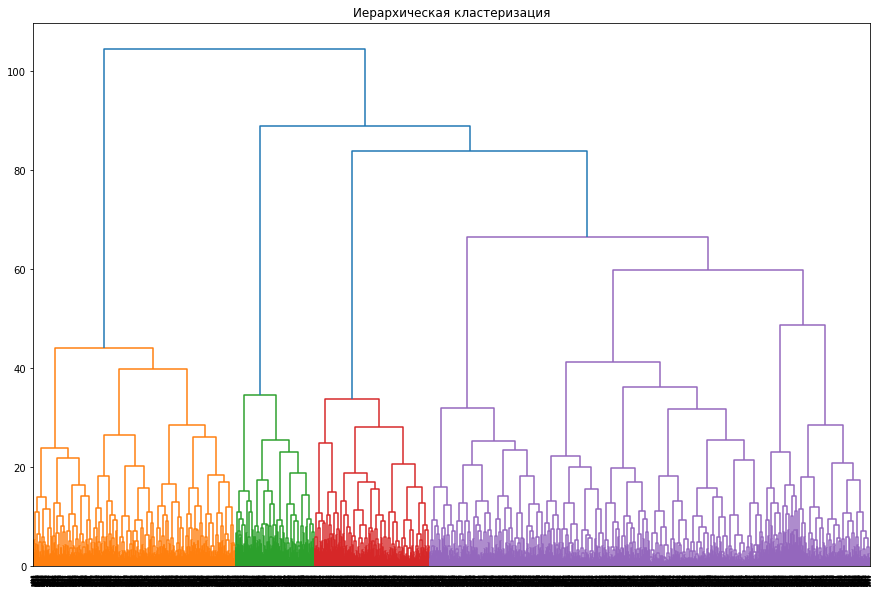

In [22]:
linked = linkage(x_sc, method = 'ward') 

plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация')
plt.show()

График показал, что оптимальное число кластеров 4, но по условиям задания мы используем 5. 

Обучим модель кластеризации на основании алгоритма K-Means, и спрогнозируем кластеры клиентов. Задаем модель k_means с числом кластеров 5 и фиксируем значение random_state. Далее прогнозируем кластеры для наблюдений и сохраняем метки кластера в поле нашего датасета. 

In [23]:
km = KMeans(n_clusters=5, random_state=0)
labels = km.fit_predict(x_sc)
data['cluster_km'] = labels

Посмотрим на средние значения признаков для кластеров. Выведем их. 

In [24]:
cluster = data.groupby('cluster_km').mean().T
cluster

cluster_km,0,1,2,3,4
gender,0.502970,0.522078,0.495050,0.485737,0.559666
near_location,0.959406,0.862338,0.000000,1.000000,0.976134
partner,0.783168,0.470130,0.463366,0.350238,0.356802
promo_friends,0.574257,0.306494,0.079208,0.240095,0.230310
phone,1.000000,0.000000,1.000000,1.000000,0.998807
contract_period,10.889109,4.787013,2.352475,1.948494,2.669451
group_visits,0.542574,0.425974,0.215842,0.341521,0.473747
age,29.982178,29.301299,28.477228,28.167987,30.125298
avg_additional_charges_total,160.761016,143.957664,135.457501,131.622204,161.657905
month_to_end_contract,9.954455,4.475325,2.198020,1.856577,2.459427


Кластер 0: 
* самый низкий процент оттока (3%)
* живут или работают недалеко от фитнес-центра
* 78% являются сотрудниками компаний-партнерами клуба
* 57% первоначально пришли в рамках акции «приведи друга» 
* самая высокая длительность текущего действующего абонемента
* самый высокий процент посещений групповых занятий (54%)
* средняя частота посещений в неделю за предыдущий месяц - 2 раза

Кластер 1:
* процент оттока - 26%
* живут или работают недалеко от фитнес-центра
* 47% являются сотрудниками компаний-партнерами клуба
* 30% первоначально пришли в рамках акции «приведи друга»
* не оставили свой номер телефона 
* 42% посещают групповые занятия
* средний срок до окончания текущего действующего абонемента - 4,5 месяцев

Кластер 2:
* процент оттока - 44%
* предположительно живут или работают в другом районе относительно фитнес-центра
* всего 8% первоначально пришли в рамках акции «приведи друга» 
* самый низкий показатель посещения групповых занятий (21%)

Кластер 3:
* самый высокий процент оттока (51%)
* живут или работают рядом с фитнес-центром
* всего 35% являются сотрудниками компаний-партнерами клуба (это самый низкий показатель)
* самый низкий показатель длительности текущего действующего абонемента 
* самый низкий показатель суммарная выручка от других услуг фитнес-центра
* самый низкий показатель срока до окончания текущего действующего абонемента
* клиенты этой группы реже всего посещают фитнес-центр (за всё время и в последний месяц)

Кластер 4:
* процент оттока - 7%
* живут или работают недалеко от фитнес-центра
* самое высокое значение суммарной выручки от других услуг фитнес-центра (161,6)
* чаще всех посещают клуб - 2.8 раз в неделю
* время с момента первого обращения в фитнес-центр - 4.8 месяцев (самое высокое значение)

Построим распределения признаков для кластеров по категориальным и числовым данным. 

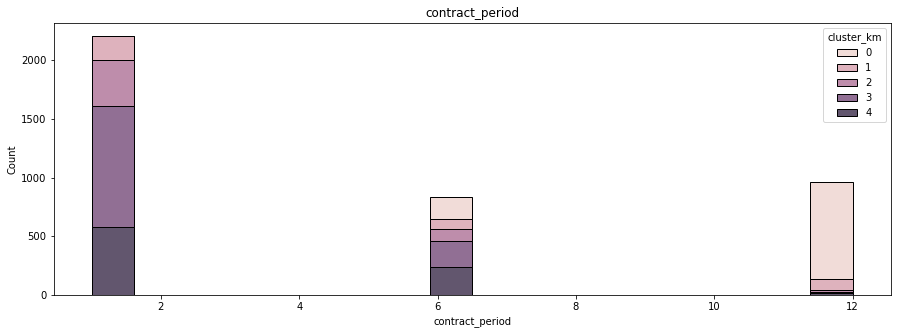

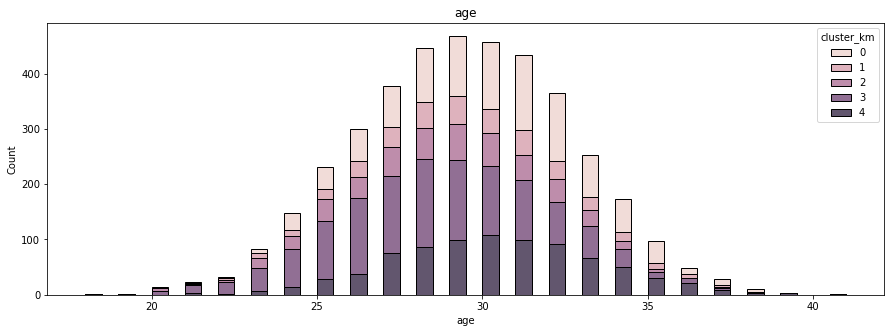

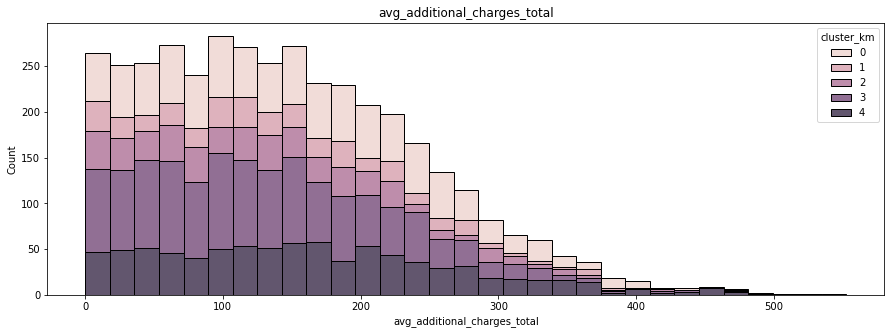

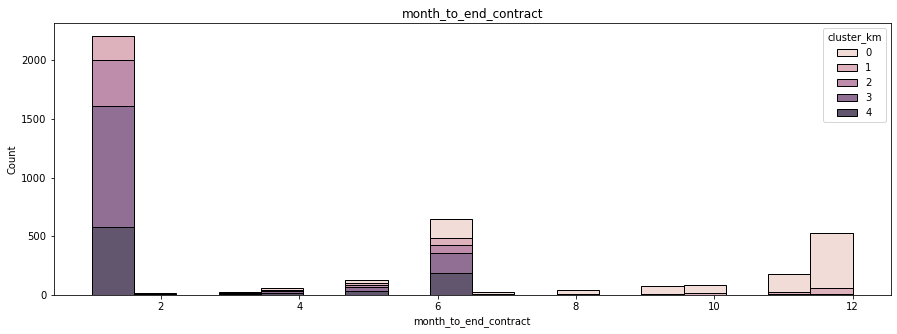

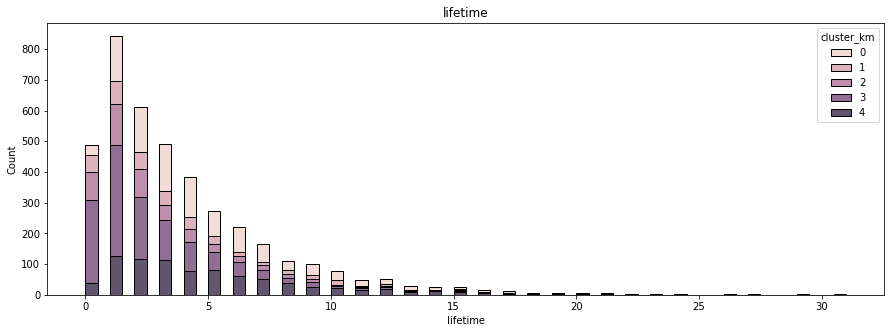

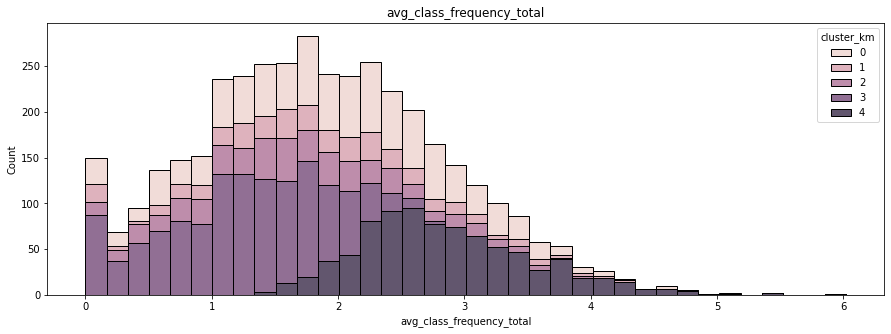

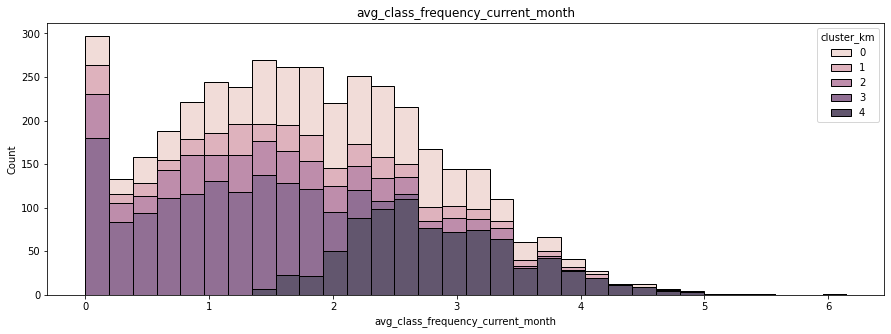

In [25]:
numerical_features = ['contract_period', 'age', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime', 
                      'avg_class_frequency_total', 'avg_class_frequency_current_month']
for n in numerical_features:
    plt.figure(figsize=(15, 5))
    sns.histplot(data=data, x=n, hue="cluster_km", multiple="stack")
    plt.title(n)
    plt.show()

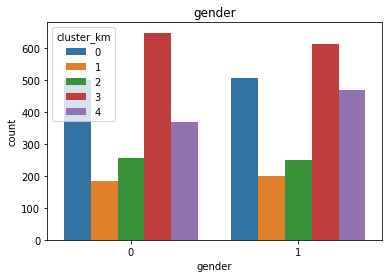

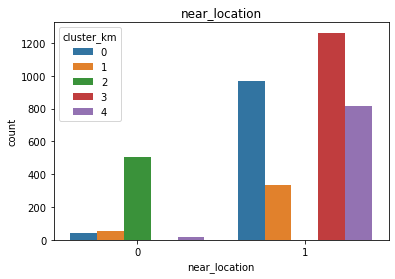

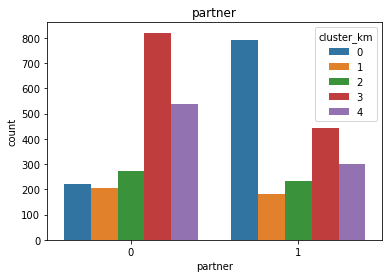

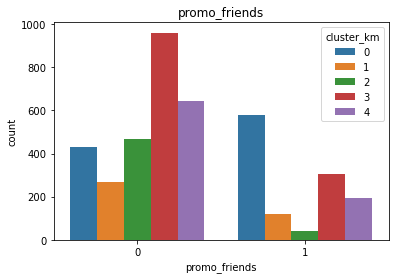

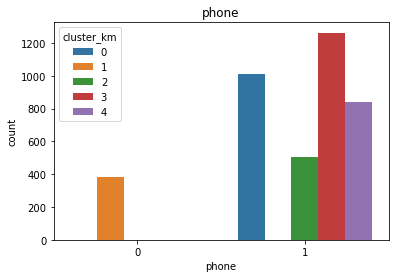

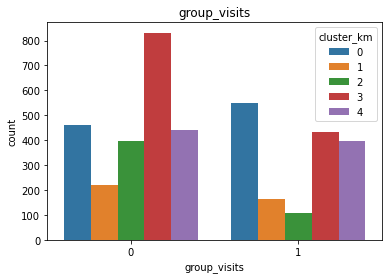

In [26]:
categorical_features = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']

for c in categorical_features:
    sns.countplot(x = data[c], hue='cluster_km', data=data)
    plt.title(c)
    plt.show()

## Сформулировать выводы и дадим рекомендации по работе с клиентами

В наше распоряжение попали множество клиентских анкет фитнес-клуба «Культуриста-датасаентиста». После предобработки данных мы провели анализ и подготовили план действий по удержанию клиентов. 

Нам были предоставлены сведения в csv-файле. По предоставленным данным мы сделали следующие выводы:
* По полу посетители распределены примерно одинаково;
* Почти 85% посетителей проживают или работают в районе, где находится фитнес-центр;
* Почти половина всех посетителей являются сотрудниками компаний-партнеров клуба; 
* 30% посетителей первоначально записались на посещение клуба в рамках акции «приведи друга»; 
* 90% посетители оставили свой контактный телефон;             
* Средняя длительность текущих действующих абонементов чуть меньше 4,6 месяцев;
* 41% посетителей посещают групповые занятия;
* Средний возрасти посетителей составляет 29 лет;
* В среднем суммарная выручка от других услуг фитнес-центра составляет 146,9;
* Средний срок до окончания текущих действующих абонементов составляет чуть больше 4 месяцев;
* Среднее время с момента первого обращения в фитнес-центр составляет 3.7 месяцев;
* Средняя частота посещений в неделю за все время с начала действия абонемента составляет 1,87 раз в неделю; 
* Средняя частота посещений в неделю за предыдущий месяц составляет 1,76 раз в неделю; 
* Среднее значение оттока составляет 26,5%.

После разделения клинтов на 2 группы (те, что попали в отток, и те что остались), мы сделали вывод, что клиентов, продолжающих посещать фитнес-центр почти в 3 раза больше чем тех, кто ушел в отток. Получили следующие выводы: 
* Распределение по полу в обеих группах примерно одинаково;
* В обеих группах большинство посетителей живут или работают в районе, где находится фитнес-центр. Также стоит заметить, что ближе живущие или работающие клиенты реже попадают в отток; 
* Для **группы оставшихся** (не попавших в отток) половина всех посетителей являются сотрудниками компаний-партнеров клуба. В **группе "оттока"** их всего 35%; 
* **Группа оставшихся** (не попавших в отток) - 35% посетителей первоначально записались на посещение клуба в рамках акции «приведи друга». **Группа "оттока"** - всего 18% посетителей первоначально записались по данной акции;
* В обеих группах 90% посетители оставили свой контактный телефон; 
* **Группа оставшихся** -- средняя длительность текущих действующих абонементов 5,7 месяцев. **Группа "оттока"** - 1,7 месяцев; 
* **Группа оставшихся** -- 46% клиентов посещают групповые занятия. **Группа "оттока"** - всего 26% клиентов; 
* Средний возраст в **Группе оставшихся** около 30 лет. В **группе "оттока"** посетители чуть младше, средний возраст 27 лет; 
* **Группа оставшихся** -- в среднем суммарная выручка от других услуг фитнес-центра составляет 158,4. **Группа "оттока"** всего 115; 
* **Группа оставшихся** -- средний срок до окончания текущих действующих абонементов составляет 5,2 месяца. Для **группы "оттока"** всего 1,6 месяцев;
* **Группа оставшихся** -- среднее время с момента первого обращения в фитнес-центр составляет 4,7 месяцев. Для **группы "оттока"** менее 1 месяца;
* **Группа оставшихся** - средняя частота посещений в неделю за все время с начала действия абонемента составляет 2 раз в неделю; Для **группы "оттока"** -- 1,4 раз в неделю;
* **Группа оставшихся** - средняя частота посещений в неделю за предыдущий месяц составляет 2 раз в неделю; Для **группы "оттока"** -- 1 раз в неделю. 

После мы нарисовали дендрограмму и узнали количество кластеров. Разделили посетителей на 5 групп. Проанализировав информацию мы пришли к следующим выводам:

**Кластер 0:** 
* самый низкий процент оттока (3%)
* живут или работают недалеко от фитнес-центра
* 78% являются сотрудниками компаний-партнерами клуба
* 57% первоначально пришли в рамках акции «приведи друга» 
* самая высокая длительность текущего действующего абонемента
* самый высокий процент посещений групповых занятий (54%)
* средняя частота посещений в неделю за предыдущий месяц - 2 раза

**Кластер 1:**
* процент оттока - 26%
* живут или работают недалеко от фитнес-центра
* 47% являются сотрудниками компаний-партнерами клуба
* 30% первоначально пришли в рамках акции «приведи друга»
* не оставили свой номер телефона 
* 42% посещают групповые занятия
* средний срок до окончания текущего действующего абонемента - 4,5 месяцев

**Кластер 2:**
* процент оттока - 44%
* предположительно живут или работают в другом районе относительно фитнес-центра
* всего 8% первоначально пришли в рамках акции «приведи друга» 
* самый низкий показатель посещения групповых занятий (21%)

**Кластер 3:**
* самый высокий процент оттока (51%)
* живут или работают рядом с фитнес-центром
* всего 35% являются сотрудниками компаний-партнерами клуба (это самый низкий показатель)
* самый низкий показатель длительности текущего действующего абонемента 
* самый низкий показатель суммарной выручка от других услуг фитнес-центра
* самый низкий показатель срока до окончания текущего действующего абонемента
* клиенты этой группы реже всего посещают фитнес-центр (за всё время и в последний месяц)

**Кластер 4:**
* процент оттока - 7%
* живут или работают недалеко от фитнес-центра
* самое высокое значение суммарной выручки от других услуг фитнес-центра (161,6)
* чаще всех посещают клуб - 2.8 раз в неделю
* время с момента первого обращения в фитнес-центр - 4,8 месяцев (самое высокое значение)

Взглянув на данные и полученные графики, можно составить портрет ушедшего клиента. Они чаще всего не являются сотрудниками компаний-партнеров клуба, они редко посещают тренировки (в том числе групповые), они приобретают абонементы на маленький срок (1-2 месяца). Можем предположить, что данных клиентов что-то не устроило и они не стали продолжать посещения. На основе этих данных можно рекомендовать следящее: 
* повысить интерес к групповым занятиям (предложить скидки на посещения; групповые занятия -- занятия для единомышленников, клиенты смогут найти новых знакомых/друзей что приведет к повышению интереса к занятиям)
* предложить заниматься с индивидуальным тренером по сниженной цене (это побудит чаще посещать зал, так как у клиента будет мотивация отходить все скидочные занятия)
* предложить хорошие цены за абонементы на 6 и 12 месяцев.  